In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mappings import map_country_id_to_country_name, map_country_name_to_country_id, map_month_id_to_datetime, \
    map_date_to_month_id

## Notebook to Plot Visualization of Posterior Predictive Samples including prediction bands and prediction interval length plots

In [80]:
model_identifier = 'model13_nb_feature_set1'
pps = pd.read_parquet(fr'C:\Users\Uwe Drauz\Documents\bachelor_thesis_local\personal_competition_data\Results\{model_identifier}_posterior_predicitve_samples.parquet')

In [81]:
# Load posterior predictive samples for each model
# Note: Careful with the order of the scientific model identifiers, it has to be the same as the order of the model identifiers
model_original_identifier = ['baseline_f_m','model13_nb_feature_set1', 'model3_zinb_feature_set1', 'model1_zinb_feature_set1', 'model4_zinb_feature_set1', 'model15_zinb_feature_set1']
scientific_model_identifiers = ['$B_{HM}$', '$M_{1, NB}$', '$M_{2, ZINB}$', '$M_{3, ZINB}$', '$M_{4, ZINB}$', '$M_{5, ZINB}$']
posterior_samples = [pd.read_parquet(fr'C:\Users\Uwe Drauz\Documents\bachelor_thesis_local\personal_competition_data\Results\{model_identifier}_posterior_predicitve_samples.parquet') for model_identifier in model_original_identifier]

In [82]:
# Probable country + year combinations of interest
country_list = ['Saudi Arabia', 'Syria', 'Ethiopia', 'Cameroon', 'Spain']
year_list = [2018, 2019, 2020, 2021, 2018]
country_year_list = list(zip(country_list, year_list))

In [83]:
# Probale country + month combinations of interest
country_list = ['Yemen', 'Syria', 'Ethiopia', 'Cameroon', 'Spain']
month_list = [469, 469, 469, 469, 469]
country_month_list = list(zip(country_list, month_list))

In [101]:
# Setting model index for single model plots
model_index = 2

## Plotting functions


Plot of posterior predictive samples for a specific country and year along with the actual observations

In [103]:
# Shaded quantile bands
def plot_country_data(df, country_name, year_start, month_start, year_end, month_end, scientific_model_identifiers, model_index):
    # Assume the map_date_to_month_id and map_country_name_to_country_id functions are defined elsewhere
    month_id_start = map_date_to_month_id(year_start, month_start)
    month_id_end = map_date_to_month_id(year_end, month_end)
    country_id = map_country_name_to_country_id(country_name)
    country_data = df[(df['country_id'] == country_id) & (df['month_id'] >= month_id_start) & (df['month_id'] <= month_id_end)]

    # Sorting by month_id
    country_data = country_data.sort_values(by='month_id')

    # Calculate mean, median, and quantiles for each month
    means = country_data.iloc[:, 3:].mean(axis=1)
    observations = country_data['ged_sb']
    
    quantiles = [0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
    quantile_data = {q: country_data.iloc[:, 3:].quantile(q, axis=1) for q in quantiles}
    
    with plt.style.context(('seaborn-whitegrid')):
        # Plotting
        plt.figure(figsize=(10, 5))
        
        
        # Plot and fill quantiles
        colors = plt.cm.Blues(np.linspace(0.5, 0.1, len(quantiles)))  # Adjusted color intensity
        prev_quantile = 0
        for i, q in enumerate(sorted(quantiles)):
            if q != 0:
                plt.plot(country_data['month_id'], quantile_data[q], label=f'{int(q*100)}% Quantile', color=colors[i])
                plt.fill_between(country_data['month_id'], quantile_data[prev_quantile], quantile_data[q], color=colors[i], alpha=0.5)
            prev_quantile = q

                # Plot the mean in red
        plt.plot(country_data['month_id'], means, label='Mean', color='red', alpha=0.5)

        # Plot the actual observations in black
        plt.plot(country_data['month_id'], observations, color='black', marker = 'o', label='Actual Observation', zorder=3, alpha = 0.5)
        # Labeling and styling
        plt.xlabel('Month')  # Change the x-axis label
        plt.ylabel('Predicted Fatalities')
        plt.title(f'Predictions of {scientific_model_identifiers[model_index]} for {map_country_id_to_country_name(country_id)} - {year_start}')
        
        # Convert month IDs to datetime objects for x-axis labels
        month_labels = [map_month_id_to_datetime(month_id).strftime('%b') for month_id in country_data['month_id']]
        plt.xticks(country_data['month_id'], month_labels, rotation=0)  # Set the x-axis labels as month abbreviations
        
        plt.legend(loc="upper left", frameon=True, framealpha=0.5)  # Add a legend with a semi-transparent frame
        plt.grid(False)
        
        # Use scientific notation for large numbers on the axes
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,6))
        
        plt.show()


Plot of the CDF of the posterior predicitve samples along with the actual observation for a specific country and month

In [104]:
def plot_cdf_with_observation(df, country_name, month_id, scientific_model_identifiers, model_index):
    country_id = map_country_name_to_country_id(country_name)
    # Filter for the specific country and month
    row = df[(df['country_id'] == country_id) & (df['month_id'] == month_id)]
    
    # Extract the draw columns as a NumPy array, ignoring NA values
    draws = row.filter(like='draw').values.flatten()
    draws = draws[~np.isnan(draws)]  # Remove NaN values
    
    # Calculate the CDF
    sorted_draws = np.sort(draws)
    cdf = np.arange(1, len(draws) + 1) / len(draws)
    
    # Map month_id to datetime object for title (including month and year)
    month_id_datetime = map_month_id_to_datetime(month_id)
    
    
    # Plot the CDF with a scientific style
    with plt.style.context(('seaborn-whitegrid')):
        plt.figure(figsize=(5, 3))
        plt.plot(sorted_draws, cdf, label='CDF of Draws', linestyle='-', color='royalblue')
        
        # Actual observation as a vertical line
        actual_observation = row['ged_sb'].values[0]  # Extract the actual observation
        plt.axvline(x=actual_observation, label='Actual Observation', color='red', linestyle='--')
        
        plt.xlabel('Draw Values')
        plt.ylabel('CDF')
        plt.title(f'CDF of Posterior Draws of {scientific_model_identifiers[model_index]} for {country_name} - {month_id_datetime.strftime("%b")} {month_id_datetime.year}')
        plt.legend(loc="lower right", frameon=True)
        plt.grid(False)
        
        # Use scientific notation for large numbers on the axes
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,8))

        plt.show()

Plot of the CDF and KDE of the posterior predicitve samples along with the actual observation for a specific country and month

In [110]:
def plot_cdf_and_kde_with_observation(df, country_name, month_id, scientific_model_identifiers, model_index):
    country_id = map_country_name_to_country_id(country_name)
    # Filter for the specific country and month
    row = df[(df['country_id'] == country_id) & (df['month_id'] == month_id)]
    
    # Extract the draw columns as a NumPy array, ignoring NA values
    draws = row.filter(like='draw').values.flatten()
    draws = draws[~np.isnan(draws)]  # Remove NaN values
    
    # Calculate the CDF
    sorted_draws = np.sort(draws)
    cdf = np.arange(1, len(draws) + 1) / len(draws)
    
    # Actual observation as a vertical line
    actual_observation = row['ged_sb'].values[0]  # Extract the actual observation
    
    # Map month_id to datetime object for title (including month and year)
    month_id_datetime = map_month_id_to_datetime(month_id)

    # Plotting
    with plt.style.context(('seaborn-whitegrid')):
        fig, ax1 = plt.subplots(figsize=(5, 3))

        # Plot CDF
        ax1.plot(sorted_draws, cdf, label='CDF of Draws', linestyle='-', color='royalblue')
        ax1.axvline(x=actual_observation, label='Actual Observation', color='red', linestyle='--')
        ax1.set_xlabel('Draw Values')
        ax1.set_ylabel('CDF')
        ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,8))

        # Create a second y-axis for the KDE plot
        ax2 = ax1.twinx()
        sns.kdeplot(draws, ax=ax2, color='dimgray', label='KDE of Draws', clip=(0, None))
        ax2.set_ylabel('Density')

        # Titles and labels
        plt.title(f'CDF and KDE of Posterior Draws of {scientific_model_identifiers[model_index]} for {country_name} - {month_id_datetime.strftime("%b")} {month_id_datetime.year}')
        # Get handles and labels for both axes
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()

        # Combine handles and labels
        handles = handles1 + handles2
        labels = labels1 + labels2

        # Create a single legend
        ax1.legend(handles, labels, loc='lower right', frameon=True, bbox_to_anchor=(1, 0.1), framealpha=0.5)

        plt.grid(False)
        plt.show()

Boxplot of prediction interval lengths with option to plot the PIL (i) excluding zero fatalitiy observations and (ii) to truncate the y-axis and (iii) considering different coverage levels

In [88]:
def plot_boxplot_of_prediction_intervals(posterior_samples: list, model_identifiers, lower_quantile, upper_quantile, without_zeros=False, truncate=None, truncate_to=None):
    interval_lengths = []
    for pps in posterior_samples:
        draw_columns = pps.filter(like='draw_').columns
        lower_quantile_value = pps[draw_columns].quantile(lower_quantile, axis=1)
        upper_quantile_value = pps[draw_columns].quantile(upper_quantile, axis=1)
        interval_length = upper_quantile_value - lower_quantile_value
        interval_lengths.append(interval_length)
        
    if without_zeros:
        interval_lengths = [interval_length[interval_length != 0] for interval_length in interval_lengths]
        
    coverage = upper_quantile - lower_quantile
    coverage = int(coverage * 100)

    # Use seaborn to plot the boxplot
    with plt.style.context(('seaborn-whitegrid')):
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=interval_lengths, color=sns.color_palette('Blues_r', 10)[6])
        if truncate is not None:
            plt.ylim(0, truncate_to)
        plt.xticks(np.arange(len(model_identifiers)), model_identifiers)
        plt.xlabel('Model')
        plt.ylabel('Prediction Interval Length')
        plt.title(f'Prediction Interval Lengths for Different Models - Coverage {coverage}%')
        plt.show()

Boxplot of prediction interval lengths with option to plot the PIL (i) excluding zero fatalitiy observations and (ii) to truncate the y-axis, but with the y-axis on a log scale

In [89]:
# Make same function but on log scale
def plot_boxplot_of_prediction_intervals_log_scale(posterior_samples: list, model_identifiers, lower_quantile, upper_quantile, without_zeros=False):
    interval_lengths = []
    for pps in posterior_samples:
        draw_columns = pps.filter(like='draw_').columns
        lower_quantile_value = pps[draw_columns].quantile(lower_quantile, axis=1)
        upper_quantile_value = pps[draw_columns].quantile(upper_quantile, axis=1)
        interval_length = upper_quantile_value - lower_quantile_value
        interval_lengths.append(interval_length)
        
    if without_zeros:
        interval_lengths = [interval_length[interval_length != 0] for interval_length in interval_lengths]
        
    coverage = upper_quantile - lower_quantile
    coverage = int(coverage * 100)

    # Use seaborn to plot the boxplot
    with plt.style.context(('seaborn-whitegrid')):
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=interval_lengths, color=sns.color_palette('Blues_r', 10)[6])
        plt.xticks(np.arange(len(model_identifiers)), model_identifiers)
        plt.xlabel('Model')
        plt.ylabel('Prediction Interval Length')
        plt.title(f'Prediction Interval Lengths for Different Models - Coverage {coverage}%')
        plt.yscale('log')
        plt.show()

# Making the Plots

## Prediction Interval Lengths Plots

Boxplot of PIL for all data with coverage 100%: (i) without runcation, (ii) with truncation at 5000

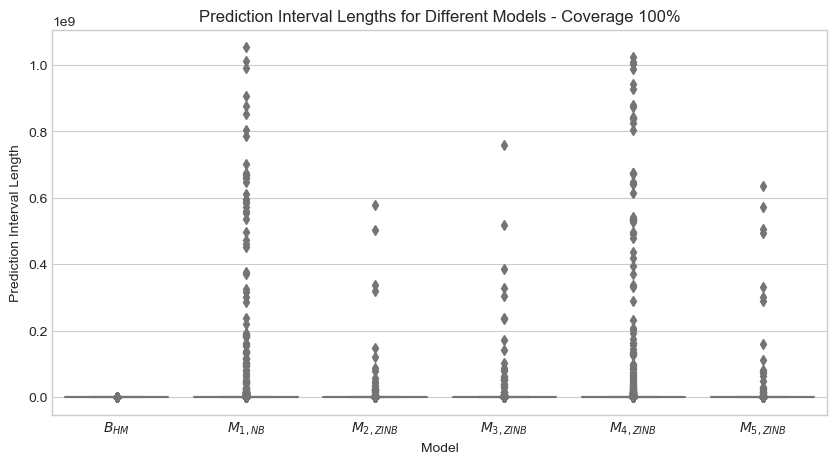

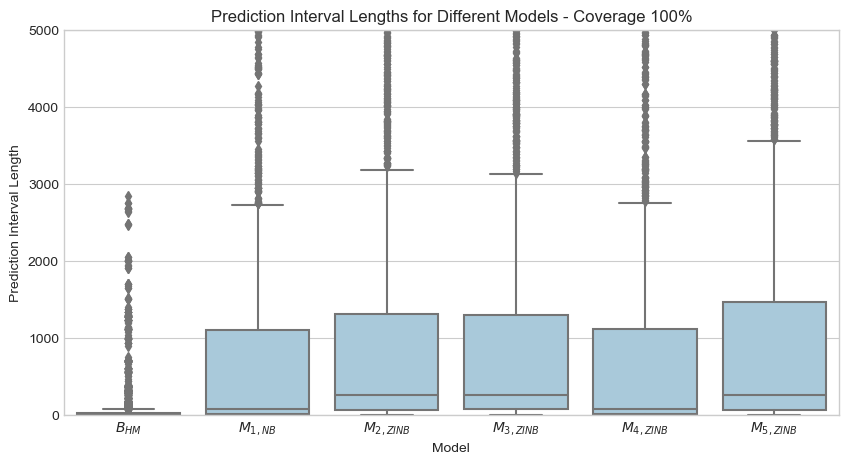

In [90]:
plot_boxplot_of_prediction_intervals(posterior_samples, scientific_model_identifiers, 0.0, 1.0, without_zeros=False)
plot_boxplot_of_prediction_intervals(posterior_samples, scientific_model_identifiers, 0.0, 1, without_zeros=False, truncate=True, truncate_to=5000)

Boxplot of PIL for data excluding zero observations with coverage 100%: (i) without truncation, (ii) with truncation at 40

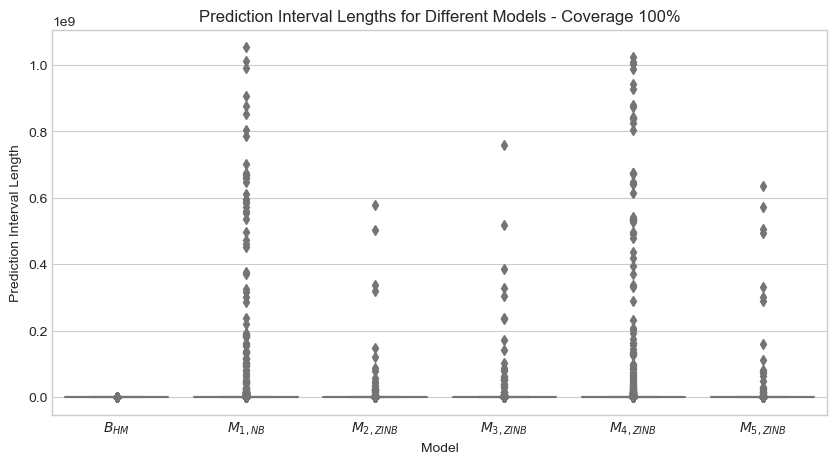

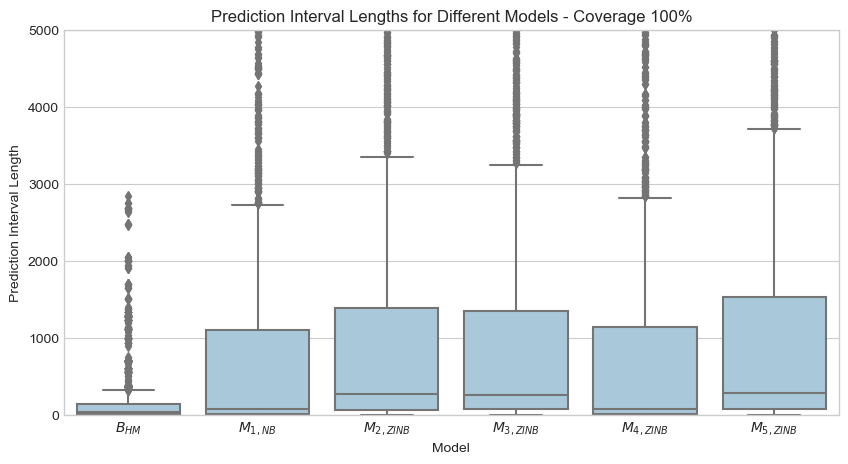

In [91]:
# Make same PIL plots with without_zeros=True
plot_boxplot_of_prediction_intervals(posterior_samples, scientific_model_identifiers, 0.0, 1.0, without_zeros=True)
plot_boxplot_of_prediction_intervals(posterior_samples, scientific_model_identifiers, 0.0, 1, without_zeros=True, truncate=True, truncate_to=5000)


## Country + Year Predictions Plots with observed fatalities

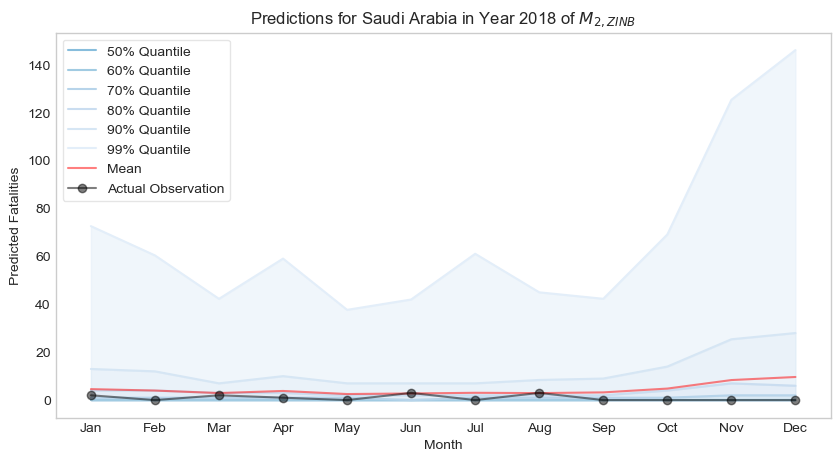

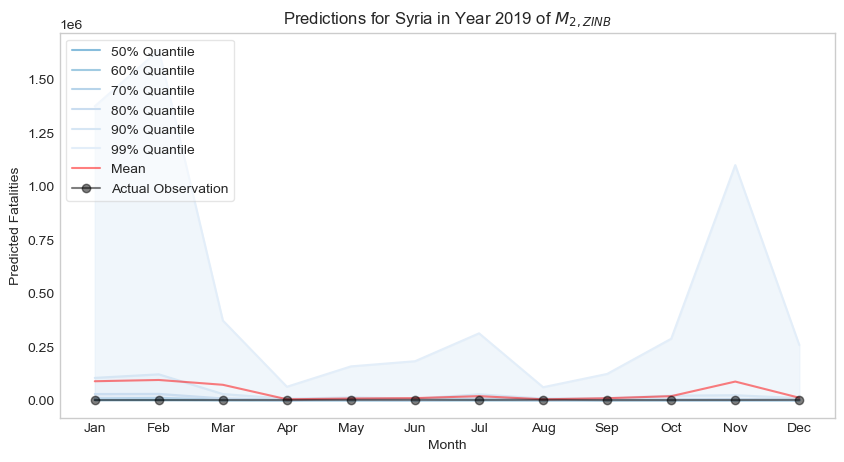

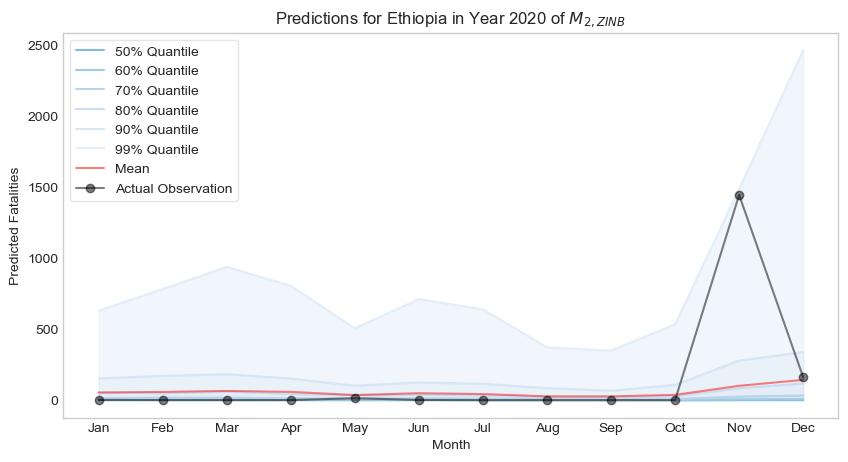

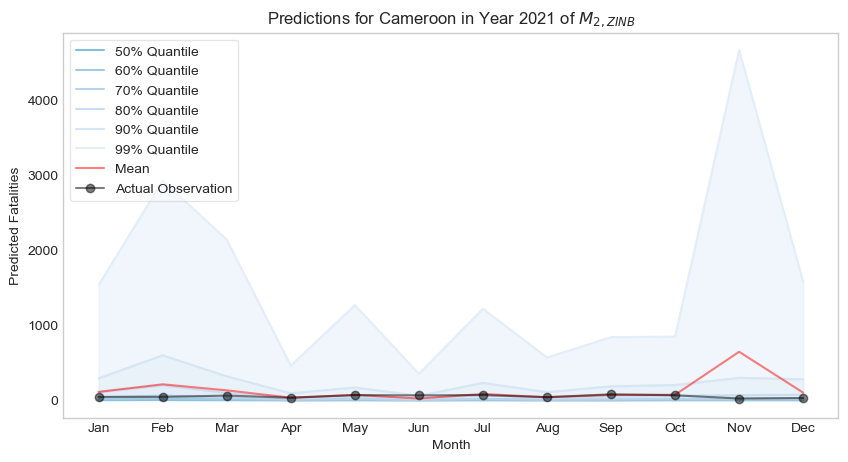

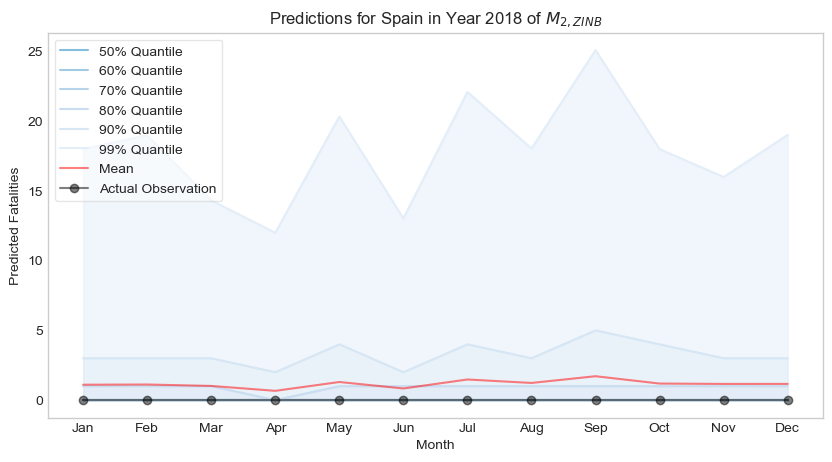

In [102]:
# Create contry data plots of the (countries, years) of interest
for country, year in country_year_list:
    plot_country_data(pps, country, year, 1, year, 12, scientific_model_identifiers, model_index)

## CDF Plots of country + month combinations with observed fatalities

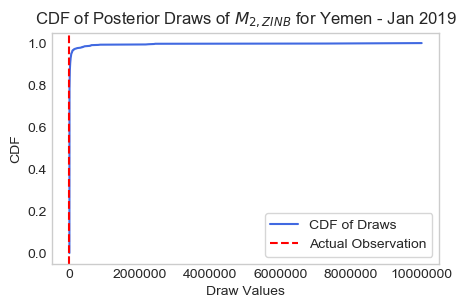

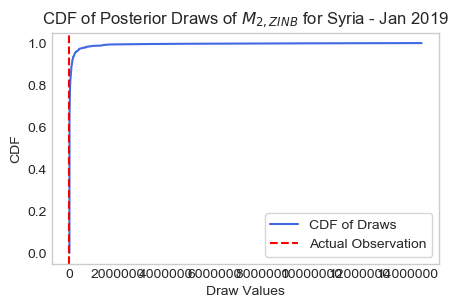

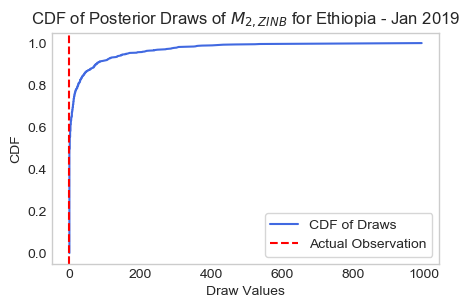

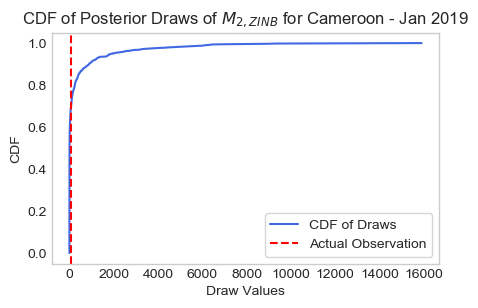

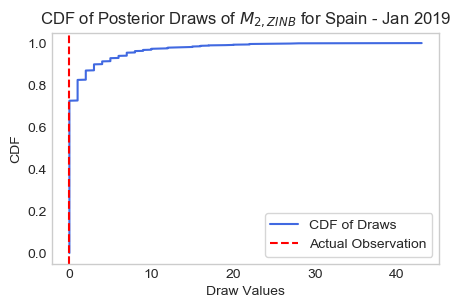

In [108]:
for country, month in country_month_list:
    plot_cdf_with_observation(pps, country, month, scientific_model_identifiers, model_index)

## CDF and KDE Plots of country + month combinations with observed fatalities

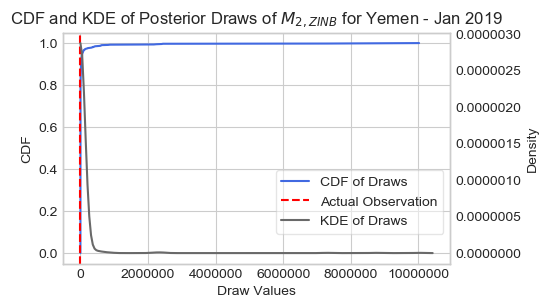

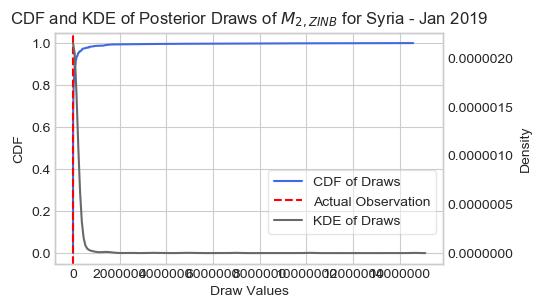

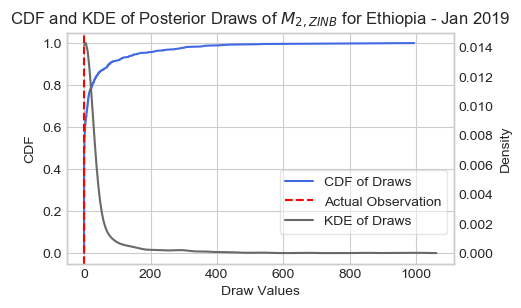

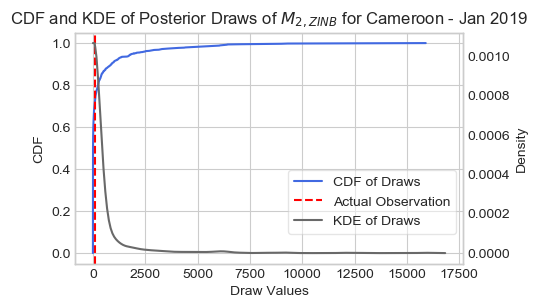

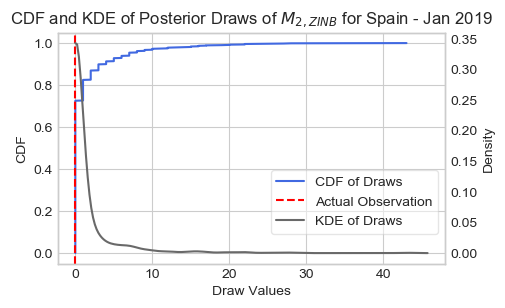

In [111]:
for country, month in country_month_list:
    plot_cdf_and_kde_with_observation(pps, country, month, scientific_model_identifiers, model_index)